# import librairies

In [1]:
import glob
import imageio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import mahotas as mt
from skimage.restoration import estimate_sigma
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
#!conda info --envs

# File reading

In [3]:
X_train_data = pd.read_pickle("data\\df_Xwfilt_train.pickle")
X_test_data = pd.read_pickle("data\\df_Xwfilt_test.pickle")
y_train_data = pd.read_pickle("data\\df_y_train.pickle")
y_test_data = pd.read_pickle("data\\df_y_test.pickle")

In [4]:
X_train_data.head(2)

,ampbw,imsizex,imsizey,edge,gabor
0,"[[121, 121, 121, 122, 128, 131, 132, 132, 131,...",451,1006,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[147, 149, 152, 158, 164, 169, 173, 174, 174,..."
1,"[[87, 83, 82, 82, 79, 53, 43, 39, 37, 37, 37, ...",588,814,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[52, 50, 43, 34, 24, 14, 2, 0, 0, 0, 0, 0, 0,..."


In [5]:
classes = [ "flat", "salt", "gasc", "nois"]
num_per_classes = {}
prev = 0
for categ in classes:
    num_per_classes[categ] = [prev , prev + len(y_train_data[y_train_data["categ"] == categ])]
    prev = prev + len(y_train_data[y_train_data["categ"] == categ])
num_per_classes

{'flat': [0, 91], 'salt': [91, 163], 'gasc': [163, 215], 'nois': [215, 300]}

Example images

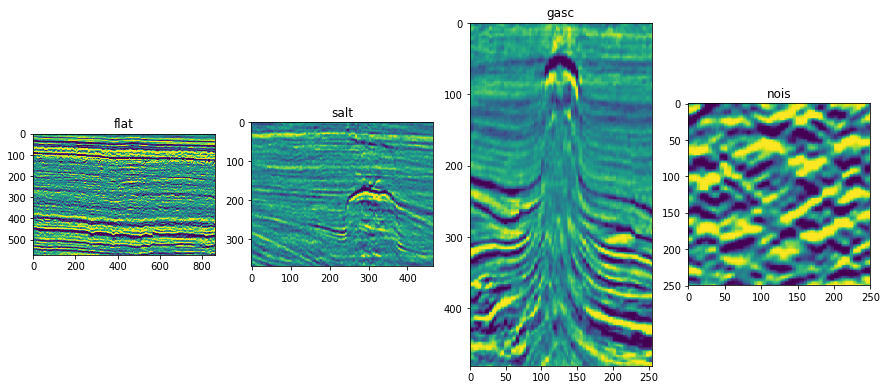

In [6]:
display_images = [random.randint(num_per_classes["flat"][0], num_per_classes["flat"][1]),
                 random.randint(num_per_classes["salt"][0], num_per_classes["salt"][1]),
                 random.randint(num_per_classes["gasc"][0], num_per_classes["gasc"][1]),
                 random.randint(num_per_classes["nois"][0], num_per_classes["nois"][1])]

fig, axs = plt.subplots(figsize=(15, 20))
for col in range (4):
    plt.subplot( 1, 4, col+1 )
    plt.imshow(X_train_data.loc[display_images[col], "ampbw" ])
    plt.title( classes[col] )
plt.show()

## Images filtered with edge detection and gabor filter

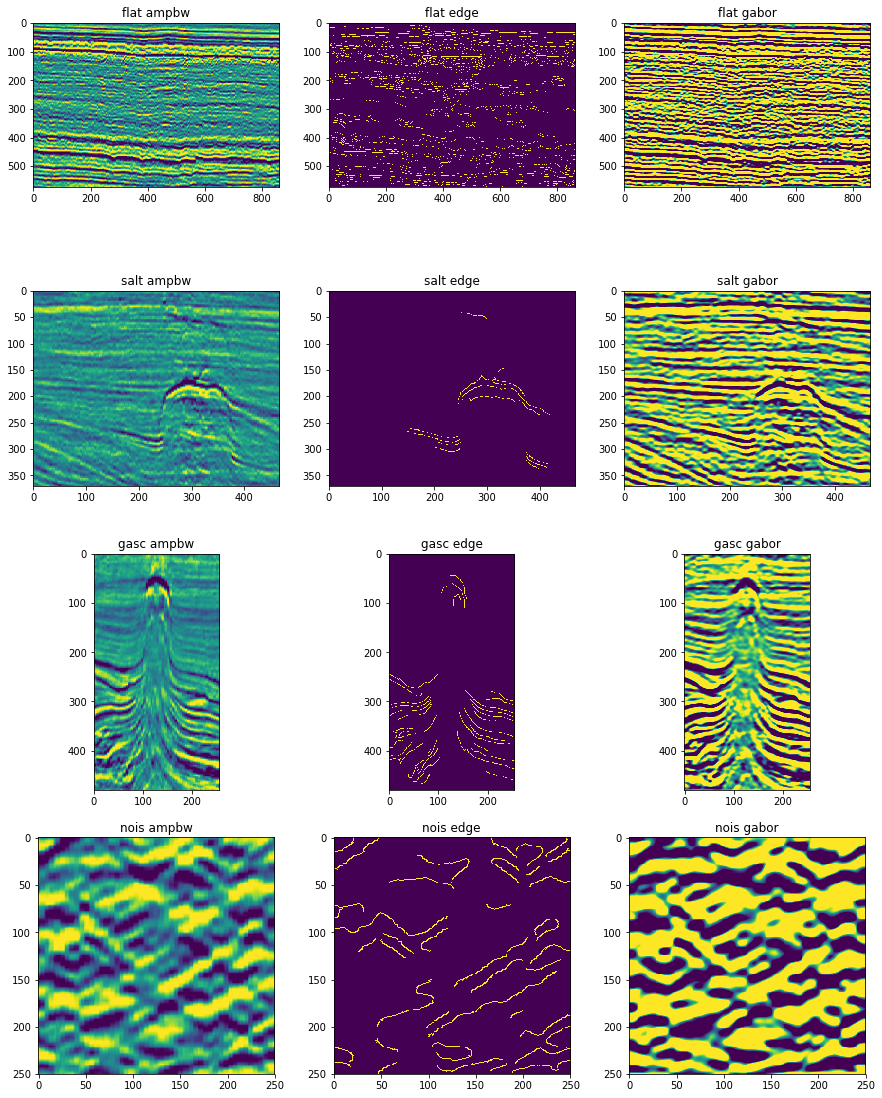

In [7]:
filters_types = [ "ampbw", "edge", "gabor" ]

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

for row in range (4):
    for col in range (3):
        plt.subplot(4, 3, row*3+col+1)
        plt.imshow(X_train_data.loc[display_images[row], filters_types[col] ])
        plt.title( classes[row] + " " + filters_types[col] )

# Feature extraction

Extract features from the images. Each images being filtered with edge detection, gabor, mean

Noise feature

In [8]:
def estimate_noise(img):
    return estimate_sigma(img, multichannel=True, average_sigmas=True)

Mean and standart deviation

In [9]:
def m_std ( img ):
    m = np.mean( img )
    std = np.std( img )
    return ( [m, std] )

Haralick features

In [10]:
def extract_haralick(img):
        # calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(img)
        # take the mean of it and return it
        ht_mean = textures.mean(axis=0)
        return (ht_mean.tolist())

Feature extraction and gathering into a single dataframe

In [11]:
def extract_features(data_frame, image_name, image_type):
    columns_names = ["noise", "mean", "std", "h_1", "h_2", "h_3", "h_4", "h_5", "h_6", "h_7", "h_8",
                                "h_9", "h_10", "h_11", "h_12", "h_13"]
    columns_names = [image_type+"_"+cname for cname in columns_names]
    df = pd.DataFrame(columns = columns_names)
    for idx,img in enumerate(data_frame[image_name]):
        L_ft = [estimate_noise(img), *m_std(img), *extract_haralick(img)]
        df.loc[idx] = L_ft
    return df

In [12]:
def gather_features(dataframe):
    df = pd.DataFrame() # empty dataframe
    images_filters = ["original", "gabor", "edge"]
    images_names = ["ampbw", "edge", "gabor"]
    for i_type in range(len(images_filters)):
        df_new = extract_features(dataframe, images_names[i_type], images_filters[i_type])
        df = pd.concat([df, df_new], axis=1)
    return df

In [13]:
Xfeature_train = gather_features(X_train_data)
Xfeature_train.head(2)

C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,original_noise,original_mean,original_std,original_h_1,original_h_2,original_h_3,original_h_4,original_h_5,original_h_6,original_h_7,...,edge_h_4,edge_h_5,edge_h_6,edge_h_7,edge_h_8,edge_h_9,edge_h_10,edge_h_11,edge_h_12,edge_h_13
0,3.138345,128.786097,59.042143,0.000684,369.178593,0.947101,3488.779280,0.182048,257.594312,13585.938528,...,11234.930247,0.541791,303.027492,42793.912898,5.727264,8.125905,0.001104,4.196930,-0.263588,0.943127
1,1.546567,127.427500,42.084995,0.000464,91.552985,0.974159,1771.436628,0.223060,254.875621,6994.193526,...,9238.826490,0.434183,314.884438,35892.402785,6.693184,9.761529,0.000683,4.517451,-0.292754,0.969045


In [14]:
Xfeature_test = gather_features(X_test_data)
Xfeature_test.head(2)

,original_noise,original_mean,original_std,original_h_1,original_h_2,original_h_3,original_h_4,original_h_5,original_h_6,original_h_7,...,edge_h_4,edge_h_5,edge_h_6,edge_h_7,edge_h_8,edge_h_9,edge_h_10,edge_h_11,edge_h_12,edge_h_13
0,2.764494,127.923554,49.277735,0.000364,228.756457,0.952876,2427.388372,0.180961,255.831422,9480.797030,...,11247.244365,0.536538,303.225288,42865.941981,5.792482,8.171281,0.001079,4.193661,-0.269964,0.937759
1,1.978964,126.853128,54.454539,0.000331,187.439783,0.968442,2969.074185,0.193987,253.746483,11688.856956,...,10188.502079,0.482696,303.552641,39467.992958,6.284950,9.104082,0.000853,4.388373,-0.291098,0.969779


In [15]:
df_all_train = pd.concat([X_train_data, Xfeature_train], axis=1)

### Save feartures in a pickle file

In [14]:
Xfeature_train.fillna(0, inplace = True)
Xfeature_train.to_pickle("data\\Xfeature_train.pkl")

In [15]:
Xfeature_test.fillna(0, inplace = True)
Xfeature_test.to_pickle("data\\Xfeature_test.pkl")

### Load features from pickle file

In [8]:
Xfeature_train = pd.read_pickle("data\\Xfeature_train.pkl")

In [9]:
Xfeature_test = pd.read_pickle("data\\Xfeature_test.pkl")

# Feature selection

reduce number of features to save computing time and avoid overfiting

In [24]:
# Feature Extraction with RFE - Recursive feature elimination
num_selected_ft = 5 # Define selected number of features wanted

# feature extraction
model = LogisticRegression()
rfe = RFE(model, num_selected_ft)
fit = rfe.fit(Xfeature_train, y_train_data)
print("Num Features: " + str(fit.n_features_))
print("Selected Features: %s" + str(fit.support_))
print("Feature Ranking: %s"+ str(fit.ranking_))

C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.2

Num Features: 5
Selected Features: %s[ True False False False False False False False False False False False
 False  True False False False False False False False  True False False
 False False False False False False False  True False False False False
 False False False False False False  True False False False False False]
Feature Ranking: %s[ 1 14 13 42 26  8 34 16 15 35  4  2 44  1 12 19 25 21 23 39 28  1 36 41
 22 30 27 33 40 38 20  1  6  9 11 24 29 17 31 32 10 37  1  3 43  5  7 18]


C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warni

In [25]:
selected_features = fit.support_
print(Xfeature_test.columns)
selected_features

Index(['original_noise', 'original_mean', 'original_std', 'original_h_1',
       'original_h_2', 'original_h_3', 'original_h_4', 'original_h_5',
       'original_h_6', 'original_h_7', 'original_h_8', 'original_h_9',
       'original_h_10', 'original_h_11', 'original_h_12', 'original_h_13',
       'gabor_noise', 'gabor_mean', 'gabor_std', 'gabor_h_1', 'gabor_h_2',
       'gabor_h_3', 'gabor_h_4', 'gabor_h_5', 'gabor_h_6', 'gabor_h_7',
       'gabor_h_8', 'gabor_h_9', 'gabor_h_10', 'gabor_h_11', 'gabor_h_12',
       'gabor_h_13', 'edge_noise', 'edge_mean', 'edge_std', 'edge_h_1',
       'edge_h_2', 'edge_h_3', 'edge_h_4', 'edge_h_5', 'edge_h_6', 'edge_h_7',
       'edge_h_8', 'edge_h_9', 'edge_h_10', 'edge_h_11', 'edge_h_12',
       'edge_h_13'],
      dtype='object')


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False])

### Save selected features

In [26]:
pickle.dump( selected_features, open( "model\\selected_features.pkl", "wb" ) )

## Feature visualisation

In [32]:
df_all = pd.concat([Xfeature_train[Xfeature_train.columns[selected_features]], y_train_data], axis=1)
df_all.head()

,original_noise,original_h_11,gabor_h_3,gabor_h_13,edge_h_8,categ
0,3.138345,5.030322,0.265391,0.201181,5.727264,flat
1,1.546567,4.098611,0.250552,0.056200,6.693184,flat
2,4.716953,5.376771,0.226348,0.191610,4.743316,flat
3,3.573080,5.127030,0.233836,0.167495,5.308969,flat
4,2.742194,4.906494,0.272558,0.184595,5.806348,flat


C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


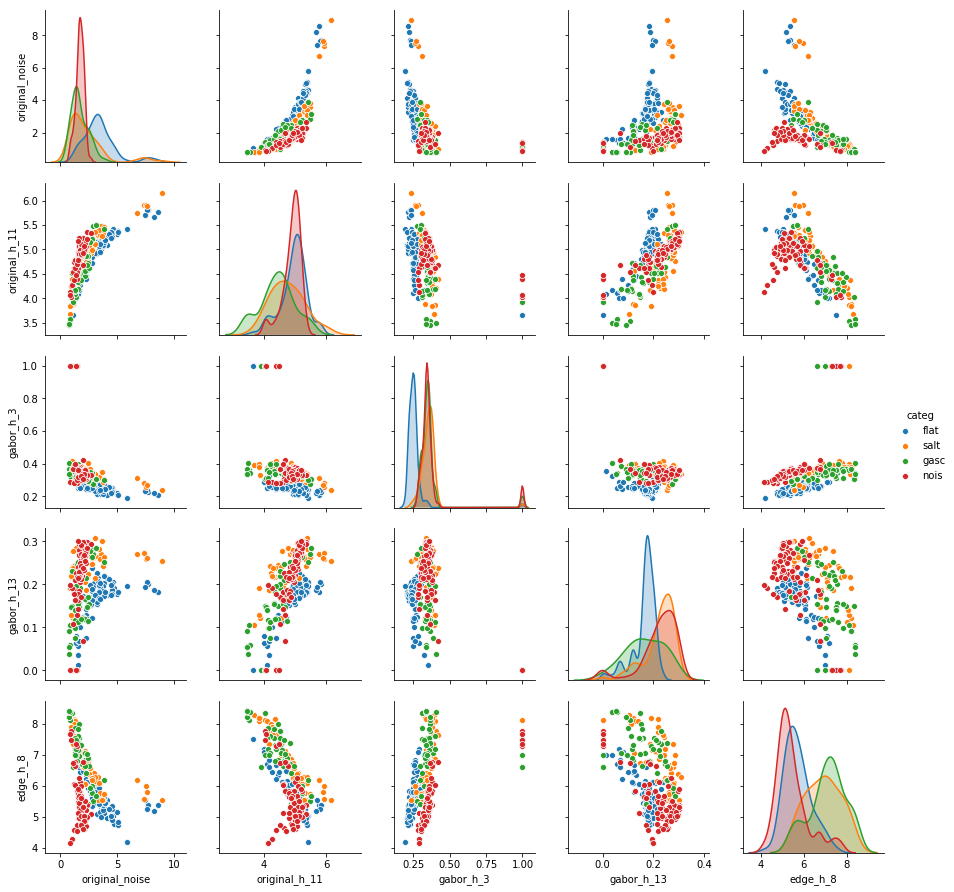

In [35]:
sns.pairplot(df_all, hue = "categ")
plt.show()

# Split the data: training / validation

Split randomly between training and validation data: test data have already been keep appart

In [36]:
X_train_ft, X_validation_ft, y_train, y_validation = train_test_split(Xfeature_train, y_train_data, test_size=0.3, random_state=42)

# Model selection

In [37]:
X_train_ft[X_train_ft.columns[selected_features]].head(2)

,original_noise,original_h_11,gabor_h_3,gabor_h_13,edge_h_8
194,1.414944,4.029595,1.000000,0.000000,6.995981
101,1.668407,4.624803,0.339426,0.194686,7.144142


In [38]:
classifiers = {
    "Linear SVM": SVC(),
    "Random forest": RandomForestClassifier(),
    "Neural network": MLPClassifier(random_state = 666),
    "XG_boost": GradientBoostingClassifier()
}

# iterate over classifiers
for name, clf in classifiers.items():
    clf.fit(X_train_ft[X_train_ft.columns[selected_features]], y_train)
    score = clf.score(X_validation_ft[X_validation_ft.columns[selected_features]], y_validation)
    print("{:12} {}".format(name,"-"*15))
    print(classification_report(y_validation, clf.predict(X_validation_ft[X_validation_ft.columns[selected_features]]), digits=3))

C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\ipykernel_

Linear SVM   ---------------
              precision    recall  f1-score   support

        flat      0.824     0.875     0.848        32
        gasc      0.400     0.143     0.211        14
        nois      1.000     0.880     0.936        25
        salt      0.448     0.684     0.542        19

   micro avg      0.722     0.722     0.722        90
   macro avg      0.668     0.646     0.634        90
weighted avg      0.727     0.722     0.709        90

Random forest ---------------
              precision    recall  f1-score   support

        flat      0.879     0.906     0.892        32
        gasc      0.412     0.500     0.452        14
        nois      1.000     0.800     0.889        25
        salt      0.500     0.526     0.513        19

   micro avg      0.733     0.733     0.733        90
   macro avg      0.698     0.683     0.686        90
weighted avg      0.760     0.733     0.743        90



C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarni

Neural network ---------------
              precision    recall  f1-score   support

        flat      0.833     0.781     0.806        32
        gasc      0.000     0.000     0.000        14
        nois      1.000     0.880     0.936        25
        salt      0.395     0.789     0.526        19

   micro avg      0.689     0.689     0.689        90
   macro avg      0.557     0.613     0.567        90
weighted avg      0.657     0.689     0.658        90

XG_boost     ---------------
              precision    recall  f1-score   support

        flat      0.935     0.906     0.921        32
        gasc      0.478     0.786     0.595        14
        nois      1.000     0.840     0.913        25
        salt      0.733     0.579     0.647        19

   micro avg      0.800     0.800     0.800        90
   macro avg      0.787     0.778     0.769        90
weighted avg      0.840     0.800     0.810        90



# Build model

Hyper parameter analysis, fit and save the model

In [39]:
parameters = {"learning_rate": [0.01, 0.05, 0.1, 0.2],
                "min_samples_split": np.linspace(0.1, 0.5, 4),
                "min_samples_leaf": np.linspace(0.1, 0.5, 4),
                "max_depth":[3, 5, 8],
#                 "max_features":["log2","sqrt"],
#                 "criterion": ["friedman_mse",  "mae"],
#                 "subsample":[0.5, 0.8, 0.9, 0.95, 1.0],
                "n_estimators":[10, 50]}

rfc = GradientBoostingClassifier()
clf = GridSearchCV(rfc, parameters, iid=False, cv=6, n_jobs=4, verbose=1)
clf.fit(X_train_ft[X_train_ft.columns[selected_features]], y_train )

clf.best_params_
clf.best_estimator_

Fitting 6 folds for each of 384 candidates, totalling 2304 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 659 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 1659 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 2304 out of 2304 | elapsed:   35.4s finished
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.1,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [41]:
choosen_model = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.1,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
choosen_model.fit(X_train_ft[X_train_ft.columns[selected_features]], y_train)

C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.1,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### Save the model to pikle 

In [118]:
pickle.dump( choosen_model, open( "model\\model_vfinal.pkl", "wb" ) )

### Load pickle model

### Results on validation set

In [42]:
y_val_pred = clf.predict(X_validation_ft[X_validation_ft.columns[selected_features]])
print(classification_report(y_validation, y_val_pred, digits=3))

              precision    recall  f1-score   support

        flat      1.000     0.906     0.951        32
        gasc      0.579     0.786     0.667        14
        nois      1.000     0.960     0.980        25
        salt      0.778     0.737     0.757        19

   micro avg      0.867     0.867     0.867        90
   macro avg      0.839     0.847     0.838        90
weighted avg      0.888     0.867     0.874        90



# Prediction analysis

Confusion matrix, classification_report: precision, recall, f1-score

In [43]:
y_test_pred = clf.predict(Xfeature_test[Xfeature_test.columns[selected_features]])
print(classification_report(y_test_data, y_test_pred, digits=3))

              precision    recall  f1-score   support

        flat      0.955     0.913     0.933        23
        gasc      0.667     0.769     0.714        13
        nois      0.957     1.000     0.978        22
        salt      0.875     0.778     0.824        18

   micro avg      0.882     0.882     0.882        76
   macro avg      0.863     0.865     0.862        76
weighted avg      0.887     0.882     0.883        76



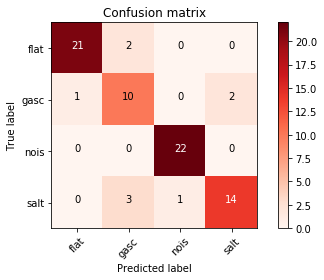

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pred, y_test_pred)
from collections import Counter
Counter(y_test_data)
selected = np.unique(y_test_data)
# itertoools is a standard library for all kinds of handy iterator manipulation
import itertools

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_data, y_test_pred)

title = 'Confusion matrix'
cmap = plt.cm.Reds

# Plot non-normalized confusion matrix.
plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(selected))
plt.xticks(tick_marks, selected, rotation=45)
plt.yticks(tick_marks, selected)

# Print the support numbers inside the plot.
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### Identification examples

In [45]:
Xfeature_test[Xfeature_test.columns[selected_features]].head(1)

,original_noise,original_h_11,gabor_h_3,gabor_h_13,edge_h_8
0,2.764494,4.713299,0.247715,0.118999,5.792482


In [46]:
y_test_data['categ'][40]

'salt'

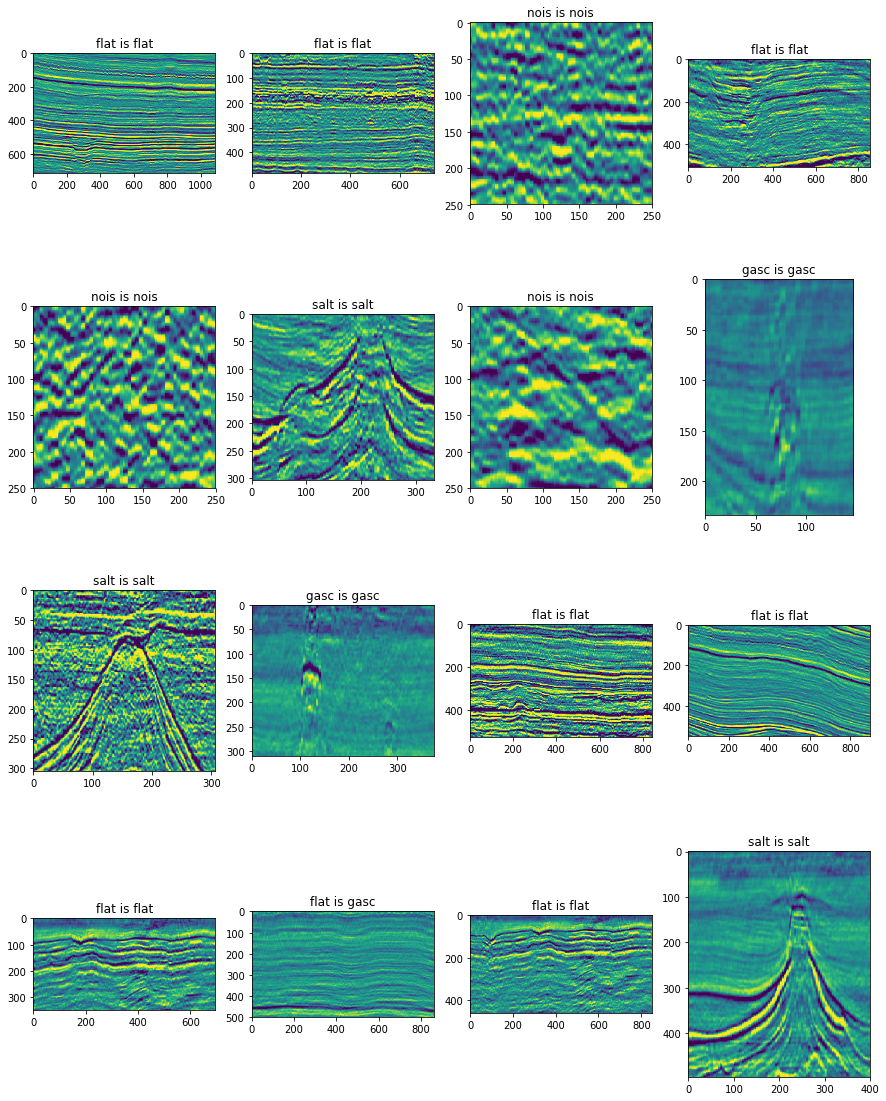

In [47]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 20))

ntests = len(X_test_data['ampbw'])
deck = list(range(1, ntests))
random.shuffle(deck)

for i, ax in enumerate(axs.flat):
    ax.imshow(X_test_data.loc[deck[i], 'ampbw'])
    ax.set_title(f"{y_test_data['categ'][deck[i]]} is {y_test_pred[deck[i]]}")